In [1]:
import os
import math
import torch
import wandb
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.utilities.model_summary import ModelSummary
from torchvision.transforms import v2
import timm
from datetime import datetime

import matplotlib.pyplot as plt

import optuna

from data.datamodule import MultiClassImageDataModule
from models.model_facedetection import TransferLearningModuleMulticlass

### Loading Configuration

In the following steps, we will load the configuration settings using the `load_configuration` function. The configuration is stored in the `config` variable which will be used throughout the script.

In [12]:
from config.load_configuration import load_configuration
config = load_configuration()

PC Name: DESKTOP-LUKAS
Loaded configuration from config/config_lukas.yaml


### Setting Seeds for Reproducibility

To ensure comparable and reproducible results, we set the random seed using the `seed_everything` function from PyTorch Lightning. This helps in achieving consistent behavior across multiple runs of the notebook.

In [3]:
pl.seed_everything(config['seed'])
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"   # disable oneDNN optimizations for reproducibility

Seed set to 42


### Checking for GPU Devices

In this step, we check for the availability of GPU devices and print the device currently being used by PyTorch. This ensures that the computations are performed on the most efficient hardware available.

In [4]:
# Check if CUDA is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Torch Version: ', torch.__version__)
print('Using device: ', device)
if device.type == 'cuda':
    print('Cuda Version: ', torch.version.cuda)
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    torch.set_float32_matmul_precision('high')

Torch Version:  2.5.1+cu121
Using device:  cuda
Cuda Version:  12.8
NVIDIA GeForce RTX 5060 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [5]:
print(torch.version.cuda)

12.1


### Defining Transformations and Instantiating DataModule

In this step, we will define the necessary data transformations and initialize the `MulticlassImageDataModule` with the provided configuration.

In [6]:
transform = v2.Compose([
    v2.Resize((300, 300)),  # Resize images to match EfficientNet input size
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
])

dm = MultiClassImageDataModule(data_dir=config['path_to_bunnie_data_aug'], name_list=config['name_list'], transform=transform, batch_size=config['batch_size'], num_workers=2, persistent_workers=True)
dm.setup()

train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
# test_loader = dm.test_dataloader()
test_loader = val_loader  # Use validation data (from Janik) for testing in this example

# Show a few images from the training set
# from torchvision.utils import make_grid
# def show_images(loader):
#     images, labels = next(iter(loader))
#     images = images[:16]  # Show only the first 16 images
#     labels = labels[:16]
#     grid = make_grid(images, nrow=4, padding=2)
#     plt.figure(figsize=(10, 10))
#     plt.imshow(grid.permute(1, 2, 0).numpy())
#     plt.title('Sample Images')
#     plt.axis('off')
#     plt.show()
#     print(labels[:16])  # Print corresponding labels
# # show_images(train_loader)

print('Train dataset size:', len(dm.train_dataset))
print('Validation dataset size:', len(dm.val_dataset))
print('Test dataset size:', len(dm.test_dataset))
print('Example train data shape:', dm.train_dataset[0][0].shape)
print('Example train label:', dm.train_dataset[0][1])
print('Example val data shape:', dm.val_dataset[0][0].shape)
print('Example val label:', dm.val_dataset[0][1])

Train dataset size: 1628
Validation dataset size: 355
Test dataset size: 355
Example train data shape: torch.Size([3, 300, 300])
Example train label: tensor([0., 1., 0., 0., 0., 0.])
Example val data shape: torch.Size([3, 300, 300])
Example val label: tensor([0., 1., 0., 0., 0., 0.])


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### Creating the Model

In this step, we will define the model architecture and print its summary using the `ModelSummary` utility from PyTorch Lightning. This provides an overview of the model's layers, parameters, and structure.

In [7]:
from models.model_facedetection import TL_EfficientNetB4, TL_ConvNextV2
# model = TL_EfficientNetB4(num_classes=len(config['name_list']))
model = TL_ConvNextV2(num_classes=len(config['name_list']))
print(ModelSummary(model, max_depth=-1))

# Initialize the Wandb logger
# add time to the name of the experiment
import datetime
now = datetime.datetime.now()
current_time = now.strftime("%Y-%m-%d_%H-%M-%S")

# Initialize wandb logger
wandb_logger = WandbLogger(
    project=config['wandb_project_name'],
    name=f"{config['wandb_experiment_name']}_{type(model).__name__}_{current_time}",
    config={
        'model': type(model).__name__,
        'dataset': 'DwarfRabbits-binary',
        'batch_size': config['batch_size'],
        'max_epochs': config['max_epochs'],
        'learning_rate': config['learning_rate']
    }
)

# Initialize Trainer with wandb logger, using early stopping callback (https://lightning.ai/docs/pytorch/stable/common/early_stopping.html)
trainer = Trainer(
    max_epochs=config['max_epochs'], 
    default_root_dir='model/checkpoint/', #data_directory, 
    accelerator="auto", 
    devices="auto", 
    strategy="auto",
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, mode='min')], 
    logger=wandb_logger
    )

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


    | Name                               | Type                  | Params | Mode 
---------------------------------------------------------------------------------------
0   | model                              | ConvNeXt              | 87.7 M | train
1   | model.stem                         | Sequential            | 6.5 K  | train
2   | model.stem.0                       | Conv2d                | 6.3 K  | train
3   | model.stem.1                       | LayerNorm2d           | 256    | train
4   | model.stages                       | Sequential            | 87.7 M | train
5   | model.stages.0                     | ConvNeXtStage         | 418 K  | train
6   | model.stages.0.downsample          | Identity              | 0      | train
7   | model.stages.0.blocks              | Sequential            | 418 K  | train
8   | model.stages.0.blocks.0            | ConvNeXtBlock         | 139 K  | train
9   | model.stages.0.blocks.0.conv_dw    | Conv2d                | 6.4 K  | train
10  | mode

## Train the model

In [ ]:
# Training of the model
trainer.fit(model=model, datamodule=dm)

# Finish wandb
wandb.finish()

# Save the trained model checkpoint
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = os.path.join(config['path_to_models'], f"{model.model_name}_model_{timestamp}.ckpt")
trainer.save_checkpoint(save_path)
print(f"Model saved to: {save_path}")
config['path_to_model'] = save_path

wandb: Currently logged in as: erzlektor (VDKI-Hasen) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ConvNeXt            | 87.7 M | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | softmax        | Softmax             | 0      | train
3 | train_accuracy | MulticlassAccuracy  | 0      | train
4 | val_accuracy   | MulticlassAccuracy  | 0      | train
5 | val_precision  | MulticlassPrecision | 0      | train
6 | val_recall     | MulticlassRecall    | 0      | train
---------------------------------------------------------------
6.2 K     Trainable params
87.7 M    Non-trainable params
87.7 M    Total params
350.796   Total estimated model params size (MB)
471       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

f:\Users\Mika\Anaconda\envs\VDKI-Projekt\Lib\site-packages\sklearn\metrics\_ranking.py:1192: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
f:\Users\Mika\Anaconda\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
f:\Users\Mika\Anaconda\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
f:\Users\Mika\Anaconda\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassRecall was called before the ``

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation Data ROC AUC,▁▅▇▆███▇▇█████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
train_acc,▁▆▆▇▇▇▇███████
train_loss,█▇▄▅▃▂▁▂▁▁▂▂▂▁
trainer/global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▁▄▇▇▆█▆██████
val_loss,█▆▄▃▃▃▂▂▁▁▁▁▁▁
val_precision,▁▂▄▇▇▆█▆██████
val_recall,▁▁▄▇▇▆█▆██████
Validation Data ROC AUC,0.99295
epoch,13


Model saved to: D:/HKA_IMS_Drive/SS25_MSYS_KAER-AI-PoseAct/21_Test_Data/Models/CNN/TL_ConvNextV2_base_model_20250628_164550.ckpt


## Hyperparameter Optimization

In [6]:
import datetime
config['sweep_id'] = datetime.datetime.now().strftime("%Y%m%d_%H%M")

from models.model_facedetection import getConvNextV2_model
from training.hyperparameter_tuning import FDOptunaTrainer

config['image_size'] = 224
def objective(trial):
    model_fct = getConvNextV2_model
    trainer = FDOptunaTrainer(
        model=model_fct,                        # Function to create the model
        config=config,
        normalize_mean=[0.485, 0.456, 0.406], 
        normalize_std=[0.229, 0.224, 0.225],
        dataset_name="DwarfRabbits-multiclass"
    )
    return trainer.run_training(trial)

# Create an Optuna study
study = optuna.create_study(direction="minimize")  # because we minimize val_loss

# Set verbosity to WARNING to reduce output clutter
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Start the hyperparameter optimization
study.optimize(objective, n_trials=config['number_of_trials'])

# Best result
print("Best trial:")
print(study.best_trial.params)
print("Best value (val_loss):", study.best_value)

[I 2025-06-29 18:38:47,903] A new study created in memory with name: no-name-b254f67a-c015-40be-9181-75c57b24b4b4
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: Currently logged in as: lukas-pelz (HKA-EKG-Signalverarbeitung) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ConvNeXt            | 88.0 M | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | softmax        | Softmax             | 0      | train
3 | train_accuracy | MulticlassAccuracy  | 0      | train
4 | val_accuracy   | MulticlassAccuracy  | 0      | train
5 | val_precision  | MulticlassPrecision | 0      | train
6 | val_recall     | MulticlassRecall    | 0      | train
---------------------------------------------------------------
263 K     Trainable params
87.7 M    Non-trainable params
88.0 M    Total params
351.827   Total estimated model params size (MB)
476       Modules in train mode
0         Modules in eval mode


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassRecall was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Validation Data ROC AUC,▁▃▅▅▇▇█▇▇██▇████████
epoch,▁▁▁▁▁▂▂▂▂▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
train_acc,▁▆▆▇▇▇▇▇▇███████████
train_loss,█▆▄▄▃▃▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
val_acc,▂▃▂▄▁▅▅▆▇▇▇▇▇▇▇▇███▇
val_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▂▂▄▁▅▅▆▇▇▇▇▇██▇███▇
val_recall,▂▃▂▄▁▅▅▆▇▇▇▇▇▇▇▇███▇
Validation Data ROC AUC,0.99015
epoch,19


Optuna Validation loss: 0.2725939154624939


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ConvNeXt            | 88.0 M | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | softmax        | Softmax             | 0      | train
3 | train_accuracy | MulticlassAccuracy  | 0      | train
4 | val_accuracy   | MulticlassAccuracy  | 0      | train
5 | val_precision  | MulticlassPrecision | 0      | train
6 | val_recall     | MulticlassRecall    | 0      | train
---------------------------------------------------------------
263 K     Trainable params
87.7 M    Non-trainable params
88.0 M    Total params
351.827   Total estimated model params size (MB)
476       Modules in train mode
0         Modules in eval mode


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassRecall was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Validation Data ROC AUC,▁▅▆▆▇▇▇▇▇▇███████████
epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train_acc,▁▅▆▇▇▇▇▇▇████████████
train_loss,█▆▄▃▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
val_acc,▁▃▅▆▇▇▇▇▇▇▇██████████
val_loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▇▆▆▇▇▇▇▇▇▇██████████
val_recall,▁▃▅▆▇▇▇▇▇▇▇██████████
Validation Data ROC AUC,0.98397
epoch,20


Optuna Validation loss: 0.36477741599082947


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ConvNeXt            | 88.0 M | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | softmax        | Softmax             | 0      | train
3 | train_accuracy | MulticlassAccuracy  | 0      | train
4 | val_accuracy   | MulticlassAccuracy  | 0      | train
5 | val_precision  | MulticlassPrecision | 0      | train
6 | val_recall     | MulticlassRecall    | 0      | train
---------------------------------------------------------------
263 K     Trainable params
87.7 M    Non-trainable params
88.0 M    Total params
351.827   Total estimated model params size (MB)
476       Modules in train mode
0         Modules in eval mode


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassRecall was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
`Trainer.fit` stopped: `max_epochs=37` reached.


Validation Data ROC AUC,▁▆▇▇█████████████████████████████████
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train_acc,▁▃▅▆▆▆▇▇▇▇▇▇█████████████████████████
train_loss,█▇▅▄▃▃▂▃▂▂▁▂▁▂▁▂▁▁▁▂▂▁▂▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇██
val_acc,▁▄▆▆▇▇▇▇▇▇▇▇▇█▇▇█████████████████████
val_loss,█▇▆▅▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▄▅▅▆▆▆▆▆▇▇▇█████████████████████████
val_recall,▁▄▆▆▇▇▇▇▇▇▇▇▇█▇▇█████████████████████
Validation Data ROC AUC,0.98141
epoch,36


Optuna Validation loss: 0.4344993531703949


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ConvNeXt            | 88.0 M | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | softmax        | Softmax             | 0      | train
3 | train_accuracy | MulticlassAccuracy  | 0      | train
4 | val_accuracy   | MulticlassAccuracy  | 0      | train
5 | val_precision  | MulticlassPrecision | 0      | train
6 | val_recall     | MulticlassRecall    | 0      | train
---------------------------------------------------------------
263 K     Trainable params
87.7 M    Non-trainable params
88.0 M    Total params
351.827   Total estimated model params size (MB)
476       Modules in train mode
0         Modules in eval mode


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassRecall was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Validation Data ROC AUC,▁▅▆██▇█
epoch,▁▁▁▂▂▂▃▃▃▅▅▅▅▆▆▆▇▇▇████
train_acc,▁▆▇▇███
train_loss,█▆▃▁▃▂▂▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇████
val_acc,▁▂▃█▇▅▇
val_loss,█▄▂▁▁▂▁
val_precision,▁▃▄█▇▅▇
val_recall,▁▂▃█▇▅▇
Validation Data ROC AUC,0.98655
epoch,6


Optuna Validation loss: 0.31950441002845764


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ConvNeXt            | 87.7 M | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | softmax        | Softmax             | 0      | train
3 | train_accuracy | MulticlassAccuracy  | 0      | train
4 | val_accuracy   | MulticlassAccuracy  | 0      | train
5 | val_precision  | MulticlassPrecision | 0      | train
6 | val_recall     | MulticlassRecall    | 0      | train
---------------------------------------------------------------
6.2 K     Trainable params
87.7 M    Non-trainable params
87.7 M    Total params
350.796   Total estimated model params size (MB)
471       Modules in train mode
0         Modules in eval mode


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassRecall was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
`Trainer.fit` stopped: `max_epochs=39` reached.


Validation Data ROC AUC,▁▅▆▆▇▇▇▇▇██████████████████████████████
epoch,▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
train_acc,▁▆▆▇▇▇█████████████████████████████████
train_loss,█▅▃▃▃▂▂▁▁▂▁▃▁▂▂▂▁▂▂▂▁▂▂▁▁▂▁▁▂▂▁▂▂▂▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▇▇▇▇▇▇▇█
val_acc,▁▆▅▅▇▆▅▆▆▆▆█▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇█▇███████
val_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▇▆▆▇▇▆▇▇▇▇█▇▇▇▇▇██████████████████████
val_recall,▁▆▅▅▇▆▅▆▆▆▆█▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇█▇███████
Validation Data ROC AUC,0.98582
epoch,38


Optuna Validation loss: 0.33601468801498413


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ConvNeXt            | 87.7 M | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | softmax        | Softmax             | 0      | train
3 | train_accuracy | MulticlassAccuracy  | 0      | train
4 | val_accuracy   | MulticlassAccuracy  | 0      | train
5 | val_precision  | MulticlassPrecision | 0      | train
6 | val_recall     | MulticlassRecall    | 0      | train
---------------------------------------------------------------
6.2 K     Trainable params
87.7 M    Non-trainable params
87.7 M    Total params
350.796   Total estimated model params size (MB)
471       Modules in train mode
0         Modules in eval mode


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassRecall was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
`Trainer.fit` stopped: `max_epochs=24` reached.


Validation Data ROC AUC,▁▄▅▆▇▇▇█▇███████████████
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
train_acc,▁▆▇▇▇▇▇█████████████████
train_loss,█▅▂▂▃▃▂▂▁▂▁▂▂▁▂▂▂▂▂▁▁▁▁▁▁▁▁▂▂▁▂▂▁▂▁▁▂▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
val_acc,▁▃▅▆▅▆▆▇██▇█████████████
val_loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▃▄▆▅▆▆▇▇█▇█████████████
val_recall,▁▃▅▆▅▆▆▇██▇█████████████
Validation Data ROC AUC,0.98677
epoch,23


Optuna Validation loss: 0.315517783164978


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ConvNeXt            | 87.7 M | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | softmax        | Softmax             | 0      | train
3 | train_accuracy | MulticlassAccuracy  | 0      | train
4 | val_accuracy   | MulticlassAccuracy  | 0      | train
5 | val_precision  | MulticlassPrecision | 0      | train
6 | val_recall     | MulticlassRecall    | 0      | train
---------------------------------------------------------------
6.2 K     Trainable params
87.7 M    Non-trainable params
87.7 M    Total params
350.796   Total estimated model params size (MB)
471       Modules in train mode
0         Modules in eval mode


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassRecall was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
`Trainer.fit` stopped: `max_epochs=38` reached.


Validation Data ROC AUC,▁▅▆▇▇▇▇▇▇▇▇▇██████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇███
train_acc,▁▄▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████████████
train_loss,█▆▄▄▃▂▃▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█████
val_acc,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████████████
val_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▆▆▆▆▇▇▇▇▇▇▇▇▇████████████████████████
val_recall,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████████████
Validation Data ROC AUC,0.98169
epoch,37


Optuna Validation loss: 0.3678447902202606


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ConvNeXt            | 87.7 M | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | softmax        | Softmax             | 0      | train
3 | train_accuracy | MulticlassAccuracy  | 0      | train
4 | val_accuracy   | MulticlassAccuracy  | 0      | train
5 | val_precision  | MulticlassPrecision | 0      | train
6 | val_recall     | MulticlassRecall    | 0      | train
---------------------------------------------------------------
6.2 K     Trainable params
87.7 M    Non-trainable params
87.7 M    Total params
350.796   Total estimated model params size (MB)
471       Modules in train mode
0         Modules in eval mode


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassRecall was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Validation Data ROC AUC,▁▃▆▆▇▇▇▇████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
train_acc,▁▅▅▇▇▇▇█████████
train_loss,█▃▄▂▂▁
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▁▄▇▇▆▇▇█▇███████
val_loss,█▄▂▃▂▁▂▁▁▁▁▁▁▁▁▁
val_precision,▁▁▆▇▅▆▇▇▇███████
val_recall,▁▄▇▇▆▇▇█▇███████
Validation Data ROC AUC,0.98805
epoch,15


Optuna Validation loss: 0.2977973520755768


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ConvNeXt            | 87.7 M | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | softmax        | Softmax             | 0      | train
3 | train_accuracy | MulticlassAccuracy  | 0      | train
4 | val_accuracy   | MulticlassAccuracy  | 0      | train
5 | val_precision  | MulticlassPrecision | 0      | train
6 | val_recall     | MulticlassRecall    | 0      | train
---------------------------------------------------------------
6.2 K     Trainable params
87.7 M    Non-trainable params
87.7 M    Total params
350.796   Total estimated model params size (MB)
471       Modules in train mode
0         Modules in eval mode


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassRecall was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
`Trainer.fit` stopped: `max_epochs=35` reached.


Validation Data ROC AUC,▁▅▆▆▇▇▇▇▇▇▇▇███████████████████████
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train_acc,▁▅▆▇▇▇▇▇▇▇▇████████████████████████
train_loss,█▅▄▃▃▂▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
val_acc,▁▄▅▆▆▇▇▇▇▇▇▇▇██████████████▇███████
val_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▄▆▆▇▇▇▇▇▇▇▇▇██████████████████████
val_recall,▁▄▅▆▆▇▇▇▇▇▇▇▇██████████████▇███████
Validation Data ROC AUC,0.98331
epoch,34


Optuna Validation loss: 0.35525766015052795


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ConvNeXt            | 87.7 M | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | softmax        | Softmax             | 0      | train
3 | train_accuracy | MulticlassAccuracy  | 0      | train
4 | val_accuracy   | MulticlassAccuracy  | 0      | train
5 | val_precision  | MulticlassPrecision | 0      | train
6 | val_recall     | MulticlassRecall    | 0      | train
---------------------------------------------------------------
6.2 K     Trainable params
87.7 M    Non-trainable params
87.7 M    Total params
350.796   Total estimated model params size (MB)
471       Modules in train mode
0         Modules in eval mode


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassRecall was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
`Trainer.fit` stopped: `max_epochs=39` reached.


Validation Data ROC AUC,▁▅▆▆▇▇▇▇▇▇▇▇███████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇██
train_acc,▁▅▇▇▇▇▇▇▇▇█▇███████████████████████████
train_loss,█▅▃▃▃▂▁▁▃▂▁▂▁▂▂▁▁▁▁▁▂▁▁▂▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
val_acc,▁▄▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████████████
val_loss,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▆▆▆▇▇▇▇▇▇▇▇▇██████████████████████████
val_recall,▁▄▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████████████
Validation Data ROC AUC,0.98202
epoch,38


Optuna Validation loss: 0.3641675114631653


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ConvNeXt            | 88.0 M | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | softmax        | Softmax             | 0      | train
3 | train_accuracy | MulticlassAccuracy  | 0      | train
4 | val_accuracy   | MulticlassAccuracy  | 0      | train
5 | val_precision  | MulticlassPrecision | 0      | train
6 | val_recall     | MulticlassRecall    | 0      | train
---------------------------------------------------------------
263 K     Trainable params
87.7 M    Non-trainable params
88.0 M    Total params
351.827   Total estimated model params size (MB)
476       Modules in train mode
0         Modules in eval mode


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassRecall was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
`Trainer.fit` stopped: `max_epochs=20` reached.


Validation Data ROC AUC,▁▄▅▆▇▇▇█████████████
epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_acc,▁▅▇▇▇▇██████████████
train_loss,█▆▅▄▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▂▁▂▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
val_acc,▁▂▄▅▆▆▇▇▇▇██████████
val_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▄▅▆▆▆▇▇▇▇██████████
val_recall,▁▂▄▅▆▆▇▇▇▇██████████
Validation Data ROC AUC,0.98832
epoch,19


Optuna Validation loss: 0.28526145219802856


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ConvNeXt            | 88.0 M | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | softmax        | Softmax             | 0      | train
3 | train_accuracy | MulticlassAccuracy  | 0      | train
4 | val_accuracy   | MulticlassAccuracy  | 0      | train
5 | val_precision  | MulticlassPrecision | 0      | train
6 | val_recall     | MulticlassRecall    | 0      | train
---------------------------------------------------------------
263 K     Trainable params
87.7 M    Non-trainable params
88.0 M    Total params
351.827   Total estimated model params size (MB)
476       Modules in train mode
0         Modules in eval mode


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassRecall was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
`Trainer.fit` stopped: `max_epochs=20` reached.


Validation Data ROC AUC,▁▄▅▆▆▇▇▇▇███████████
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇████
train_acc,▁▅▆▇▇▇█▇████████████
train_loss,█▇▆▅▄▃▃▃▃▂▁▂▂▁▂▂▂▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▇▇▇▇▇█████
val_acc,▁▅▄▆▆▇▇▇▇▇▇▇████████
val_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▆▅▆▆▇▇▇▇▇▇█████████
val_recall,▁▅▄▆▆▇▇▇▇▇▇▇████████
Validation Data ROC AUC,0.98741
epoch,19


Optuna Validation loss: 0.3164723515510559


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ConvNeXt            | 88.0 M | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | softmax        | Softmax             | 0      | train
3 | train_accuracy | MulticlassAccuracy  | 0      | train
4 | val_accuracy   | MulticlassAccuracy  | 0      | train
5 | val_precision  | MulticlassPrecision | 0      | train
6 | val_recall     | MulticlassRecall    | 0      | train
---------------------------------------------------------------
263 K     Trainable params
87.7 M    Non-trainable params
88.0 M    Total params
351.827   Total estimated model params size (MB)
476       Modules in train mode
0         Modules in eval mode


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassRecall was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
`Trainer.fit` stopped: `max_epochs=20` reached.


Validation Data ROC AUC,▁▄▅▆▇▇▇▇████████████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
train_acc,▁▅▆▇▇▇██████████████
train_loss,█▆▄▃▃▂▂▂▁▂▁▂▁▂▁▁▁▂▂▁▁▁▁▁▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▂
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
val_acc,▁▂▄▅▆▆▆▇▆▇▇▇▇█▇█████
val_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▄▅▆▆▆▇▇▇▇▇▇▇█▇█████
val_recall,▁▂▄▅▆▆▆▇▆▇▇▇▇█▇█████
Validation Data ROC AUC,0.98852
epoch,19


Optuna Validation loss: 0.28412315249443054


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ConvNeXt            | 88.0 M | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | softmax        | Softmax             | 0      | train
3 | train_accuracy | MulticlassAccuracy  | 0      | train
4 | val_accuracy   | MulticlassAccuracy  | 0      | train
5 | val_precision  | MulticlassPrecision | 0      | train
6 | val_recall     | MulticlassRecall    | 0      | train
---------------------------------------------------------------
263 K     Trainable params
87.7 M    Non-trainable params
88.0 M    Total params
351.827   Total estimated model params size (MB)
476       Modules in train mode
0         Modules in eval mode


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassRecall was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Validation Data ROC AUC,▁▃▅▆▇▇▇▇█▇██████
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
train_acc,▁▆▆▇▇▇██████████
train_loss,█▆▄▃▃▃▂▂▂▂▂▂▃▂▂▂▂▁▁▂▁▂▁▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
val_acc,▁▄▅▆▅▇▆▆▇▇▇▇▇███
val_loss,█▄▃▂▂▁▂▂▁▁▁▁▁▁▁▁
val_precision,▁▄▄▅▅▇▆▆█▇█▇▇███
val_recall,▁▄▅▆▅▇▆▆▇▇▇▇▇███
Validation Data ROC AUC,0.99028
epoch,15


Optuna Validation loss: 0.2578020989894867


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ConvNeXt            | 88.0 M | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | softmax        | Softmax             | 0      | train
3 | train_accuracy | MulticlassAccuracy  | 0      | train
4 | val_accuracy   | MulticlassAccuracy  | 0      | train
5 | val_precision  | MulticlassPrecision | 0      | train
6 | val_recall     | MulticlassRecall    | 0      | train
---------------------------------------------------------------
263 K     Trainable params
87.7 M    Non-trainable params
88.0 M    Total params
351.827   Total estimated model params size (MB)
476       Modules in train mode
0         Modules in eval mode


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassRecall was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Validation Data ROC AUC,▁▄▆▇▇▇▇▇█████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
train_acc,▁▆▇▇▇▇▇▇█████
train_loss,█▅▃▃▃▂▂▂▃▂▂▂▄▂▁▁▂▂▂▁▁▂▂▁▂▁▁▂▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
val_acc,▁▁▃▅▅▆▆▆▇▇▇██
val_loss,█▄▃▂▂▂▁▁▁▁▁▁▁
val_precision,▁▁▃▄▅▆▅▆▇▇▆██
val_recall,▁▁▃▅▅▆▆▆▇▇▇██
Validation Data ROC AUC,0.98982
epoch,12


Optuna Validation loss: 0.2601087987422943


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ConvNeXt            | 88.0 M | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | softmax        | Softmax             | 0      | train
3 | train_accuracy | MulticlassAccuracy  | 0      | train
4 | val_accuracy   | MulticlassAccuracy  | 0      | train
5 | val_precision  | MulticlassPrecision | 0      | train
6 | val_recall     | MulticlassRecall    | 0      | train
---------------------------------------------------------------
263 K     Trainable params
87.7 M    Non-trainable params
88.0 M    Total params
351.827   Total estimated model params size (MB)
476       Modules in train mode
0         Modules in eval mode


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassRecall was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Validation Data ROC AUC,▁▅▇▇▇▇▇█▇▇▇
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
train_acc,▁▆▇▇▇▇█████
train_loss,█▄▄▄▂▂▂▁▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▂▁▂▂▁▁▁▁▁▂▂▁▁▂▁▁▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇▇███
val_acc,▁▃▂▅▅▆▂▆██▇
val_loss,█▄▃▃▃▁▂▁▁▁▂
val_precision,▁▃▃▆▆▆▄▇██▇
val_recall,▁▃▂▅▅▆▂▆██▇
Validation Data ROC AUC,0.98964
epoch,10


Optuna Validation loss: 0.2721419036388397


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ConvNeXt            | 88.0 M | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | softmax        | Softmax             | 0      | train
3 | train_accuracy | MulticlassAccuracy  | 0      | train
4 | val_accuracy   | MulticlassAccuracy  | 0      | train
5 | val_precision  | MulticlassPrecision | 0      | train
6 | val_recall     | MulticlassRecall    | 0      | train
---------------------------------------------------------------
263 K     Trainable params
87.7 M    Non-trainable params
88.0 M    Total params
351.827   Total estimated model params size (MB)
476       Modules in train mode
0         Modules in eval mode


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassRecall was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Validation Data ROC AUC,▁▆▆█▇█▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
train_acc,▁▆▇▇▇██
train_loss,█▄▃▄▃▂▂▁▂▂▂▃▄▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▁▂▅▇███
val_loss,█▅▃▁▂▂▂
val_precision,▁▃▅▇▇██
val_recall,▁▂▅▇███
Validation Data ROC AUC,0.98756
epoch,6


Optuna Validation loss: 0.3310141861438751


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ConvNeXt            | 88.0 M | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | softmax        | Softmax             | 0      | train
3 | train_accuracy | MulticlassAccuracy  | 0      | train
4 | val_accuracy   | MulticlassAccuracy  | 0      | train
5 | val_precision  | MulticlassPrecision | 0      | train
6 | val_recall     | MulticlassRecall    | 0      | train
---------------------------------------------------------------
263 K     Trainable params
87.7 M    Non-trainable params
88.0 M    Total params
351.827   Total estimated model params size (MB)
476       Modules in train mode
0         Modules in eval mode


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassRecall was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Validation Data ROC AUC,▁▄▅▆▆▇▇▇▇██████████
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
train_acc,▁▆▆▇▇▇█████████████
train_loss,█▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▂▂▂▂▃▂▂▁▁▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇████
val_acc,▁▃▅▆▇▇▇▇▇█████▇████
val_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▂▅▅▆▇▇▆▇█▇██▇▇██▇█
val_recall,▁▃▅▆▇▇▇▇▇█████▇████
Validation Data ROC AUC,0.98978
epoch,18


Optuna Validation loss: 0.2594107687473297


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ConvNeXt            | 88.0 M | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | softmax        | Softmax             | 0      | train
3 | train_accuracy | MulticlassAccuracy  | 0      | train
4 | val_accuracy   | MulticlassAccuracy  | 0      | train
5 | val_precision  | MulticlassPrecision | 0      | train
6 | val_recall     | MulticlassRecall    | 0      | train
---------------------------------------------------------------
263 K     Trainable params
87.7 M    Non-trainable params
88.0 M    Total params
351.827   Total estimated model params size (MB)
476       Modules in train mode
0         Modules in eval mode


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassRecall was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Validation Data ROC AUC,▁▃▅▆▇▇█████████
epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
train_acc,▁▆▇▇▇█▇████████
train_loss,█▄▄▃▂▃▂▂▂▂▁▁▁▂▂▁▁▁▂
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
val_acc,▁▅▆▅▆▅▇▇███████
val_loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁
val_precision,▁▄▅▅▆▆▇▇█▇█▇███
val_recall,▁▅▆▅▆▅▇▇███████
Validation Data ROC AUC,0.9903
epoch,14


Optuna Validation loss: 0.2633392810821533


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | model          | ConvNeXt            | 88.0 M | train
1 | criterion      | CrossEntropyLoss    | 0      | train
2 | softmax        | Softmax             | 0      | train
3 | train_accuracy | MulticlassAccuracy  | 0      | train
4 | val_accuracy   | MulticlassAccuracy  | 0      | train
5 | val_precision  | MulticlassPrecision | 0      | train
6 | val_recall     | MulticlassRecall    | 0      | train
---------------------------------------------------------------
263 K     Trainable params
87.7 M    Non-trainable params
88.0 M    Total params
351.827   Total estimated model params size (MB)
476       Modules in train mode
0         Modules in eval mode


c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassRecall was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Validation Data ROC AUC,▁▃▅▇▇▇███████
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
train_acc,▁▅▆▇▇▇▇██████
train_loss,█▇▇▅▅▄▃▃▃▂▂▄▂▃▁▂▃▁▂▂▂▁▁▁▂▂▂▂▂▁▁▃▁▂▁▁▁▁▃▁
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
val_acc,▁▆▅▄▇▇▇▇▇████
val_loss,█▄▃▂▂▁▁▁▁▁▁▁▁
val_precision,▁▆▅▅▇▇█▇█████
val_recall,▁▆▅▄▇▇▇▇▇████
Validation Data ROC AUC,0.98751
epoch,12


Optuna Validation loss: 0.29533612728118896
Best trial:
{'batch_size': 64, 'image_size': 300, 'max_epochs': 24, 'accumulate_grad_batches': 1, 'precision': '16-mixed', 'optimizer': 'AdamW', 'learning_rate': 0.00025362959450590003, 'weight_decay': 0.0009073540762400554, 'scheduler': 'CosineAnnealingLR', 'model_classifier_layers': 2}
Best value (val_loss): 0.2578020989894867


In [7]:
optuna.visualization.plot_optimization_history(study)

In [8]:
optuna.visualization.plot_param_importances(study)

## Load pretrained model and perform evaluation

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7373361587524414
        test_loss           0.23408767580986023
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.23408767580986023, 'test_acc': 0.7373361587524414}]

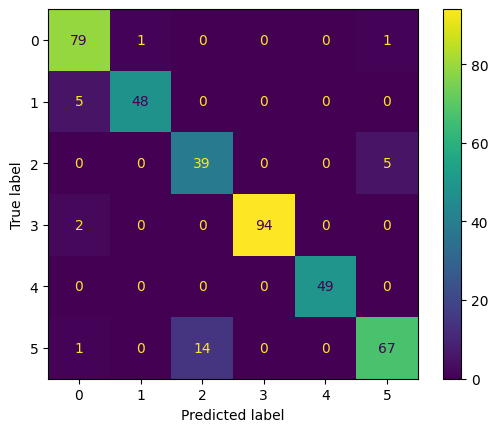

In [14]:
# model = TransferLearningModuleMulticlass.load_from_checkpoint(
#     config['path_to_model'],
#     model=timm.create_model('efficientnet_b4', pretrained=False, num_classes=len(config['name_list'])),
#     num_classes=len(config['name_list'])
# )

# Load the pretrained model from checkpoint
# model = TransferLearningModuleMulticlass.load_from_checkpoint(
#     config['path_to_model'],
#     model=timm.create_model('ConvNextV2', pretrained=False, num_classes=len(config['name_list'])),
#     num_classes=len(config['name_list'])
# )

eval_trainer = Trainer(
    max_epochs=config['max_epochs'], 
    default_root_dir='model/checkpoint/', #data_directory, 
    accelerator="auto", 
    devices="auto", 
    strategy="auto",
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, mode='min')], 
    logger=False
    )

model = TL_ConvNextV2.load_from_checkpoint(config['path_to_model'], amount_of_trainable_linear_layers=1)


# Put model in evaluation mode and move to correct device
model.eval()

eval_trainer.test(model=model, dataloaders=val_loader)

In [ ]:
# Show information about the test_loader
print("Test DataLoader Info:")
print(f"Batch size: {test_loader.batch_size}")
print(f"Number of batches: {len(test_loader)}")
print(f"Shuffle: {test_loader.shuffle if hasattr(test_loader, 'shuffle') else 'N/A'}")
print(f"Number of workers: {test_loader.num_workers}")
print(f"Dataset: {test_loader.dataset}")
print(f"Sampler: {test_loader.sampler}")
print(f"Drop last: {test_loader.drop_last}")
print(f"Pin memory: {test_loader.pin_memory}")
print(f"Persistent workers: {test_loader.persistent_workers if hasattr(test_loader, 'persistent_workers') else 'N/A'}")
print(f"Prefetch factor: {test_loader.prefetch_factor if hasattr(test_loader, 'prefetch_factor') else 'N/A'}")
print(f"Timeout: {test_loader.timeout}")

# Show a batch of test images, their shapes, and model predictions

images, labels = next(iter(test_loader))
print("Test batch images shape:", images.shape)
print("Test batch labels shape:", labels.shape)

# Move images to the correct device
images = images.to(device)
model = model.to(device)
model.eval()

with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

print("Predicted labels:", preds.cpu().numpy())
print("True labels:     ", labels.cpu().numpy())